In [9]:
from scripts import Diatom

In [10]:
diatom = Diatom("iLB1027_lipid.xml", "DM")

'R_AAL(fum)_c' is not a valid SBML 'SId'.
'R_sink_Asn-X-Ser_Thr_c' is not a valid SBML 'SId'.


In [11]:
def polytope_pipeline(reactions: tuple[str, str], n_angles: int = 360, delta: float = 0.01, n_clusters: int = 20):
    diatom.set_objective_functions({reactions[1]: 1.0})
    diatom.analyze.project_polytope_2d(reactions, n_angles = n_angles)
    diatom.grid.sample_polytope(delta = delta)
    diatom.grid.debug_plot(delta = delta)
    diatom.analyze.qualitative_analysis(only_load=False, x_limits=(-400,0))
    diatom.clustering.set_grid_clusters('hierarchical', k = n_clusters)
    #df = diatom.clustering.get_grid_cluster_qual_profiles(threshold=0.8, changing= True)
    #diatom.clustering.compare_clusters(df, reactions[0], reactions[1]).head(200)
    diatom.plot.plot_sampled_polytope(show_boundary=True)


def analyze_reactions(reaction_list1: list[str], reaction_list2: list[str], n_angles: int = 360, delta: float = 0.0125) -> None:
    for reaction1 in reaction_list1:
        for reaction2 in reaction_list2:
            polytope_pipeline((reaction1, reaction2), n_angles = n_angles, delta = delta)


Maximize
1.0*DM_biomass_c - 1.0*DM_biomass_c_reverse_c49c1


/home/chuckolate/miniconda3/envs/benpy310_linux/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


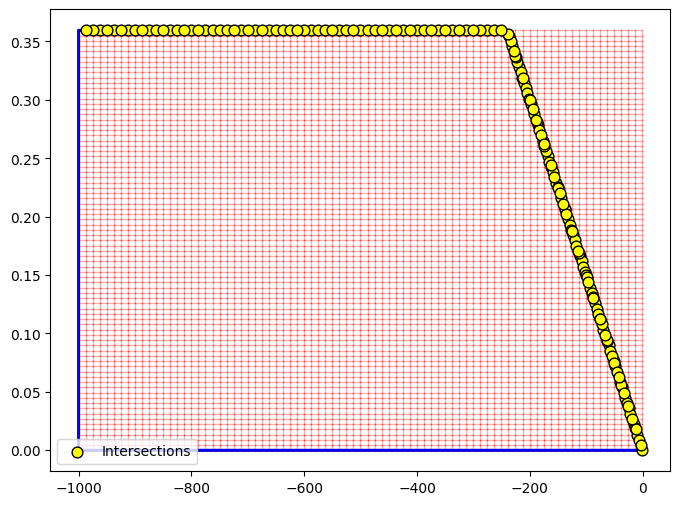

Running qualitative fva over grid feasible points...
No reactions previously selected for FVA and clustering!
Setting reactions for analysis...

Analyzing point feasibility....


 27%|██▋       | 505/1889 [1:01:20<4:10:08, 10.84s/it]

In [ ]:
reactions1 = ["EX_photon_e"]
reactions2 = ["DM_biomass_c"]

analyze_reactions(reactions1, reactions2)
